<a href="https://colab.research.google.com/github/Ansuman09/TwitterStockAnalysis/blob/main/TwitterPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Twitter Stock Price prediction

In [1]:
import pandas as pd
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## The data for this project was obtained from Yahoo finance website
Let's read the data

In [7]:
df=pd.read_csv('Twitter.csv')


In [8]:
df['date']=pd.to_datetime(df['date'],dayfirst=True)
df=df.sort_values('date')

df.head()

,date,open,high,low,close,volume
0,2013-11-07,45.10,50.09,44.00,44.90,117701600
1,2013-11-08,45.93,46.94,40.69,41.65,27925300
2,2013-11-11,40.50,43.00,39.40,42.90,16113900
3,2013-11-12,43.66,43.78,41.83,41.90,6316700
4,2013-11-13,41.03,42.87,40.76,42.60,8688300


In [9]:
#to make sure we start from the month's beginning
df=df.iloc[16:,:]
df.head()

,date,open,high,low,close,volume
16,2013-12-02,41.79,42.00,40.40,40.78,6424300
17,2013-12-03,40.69,41.60,40.54,41.37,5771000
18,2013-12-04,41.27,43.92,41.27,43.69,11014900
19,2013-12-05,43.45,46.35,42.83,45.62,11729400
20,2013-12-06,45.75,45.80,44.54,44.95,6230000


In [10]:
#no of days recorded in each day
# df['date'].str.extract('(.+)')

years=pd.DatetimeIndex(df['date']).year.unique()

num_of_days_recorded_in_a_month=[]
for year in years[1:-2]:
  for month in range(2,13):
    #12 months
    number_of_days=df[(df['date']>=f'{year}-{month-1}') & (df['date']<=f'{year}-{month}')].shape[0]
    num_of_days_recorded_in_a_month.append(number_of_days)

In [11]:
avg_num_days=np.array(num_of_days_recorded_in_a_month)
avg_num_days.mean()

21.662337662337663

In each month there are roughly 21 days in which the market data has been recorded in the dataset.

Let's visualize this data as a timeseries

In [12]:
avg_stock_price=df['close'].mean()
avg_stock_price

35.59265344664779

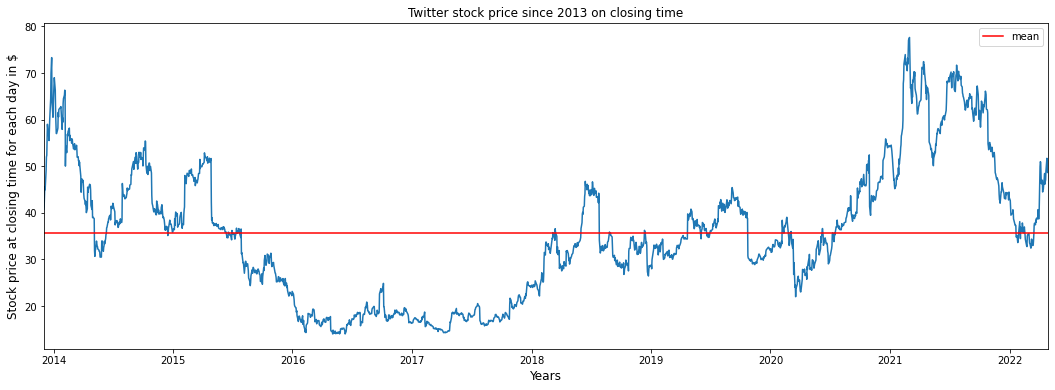

In [13]:
plt.figure(figsize=(18,6))
plt.plot(df['date'],df['close'])
plt.ylabel('Stock price at closing time for each day in $',fontsize=12)
plt.xlabel('Years',fontsize=12)
plt.title('Twitter stock price since 2013 on closing time')
plt.axhline(y=avg_stock_price,color='r',linestyle='-',label='mean')
plt.xlim(df['date'].min(),df['date'].max())
plt.legend();
  

This following function will convert the dataset into a set of features and labels. 


If a given time series has the data [1,2,3,4,5,6] then it will return

[1,2,3,4]->[5]    ;
[2,3,4,5]->[6]
based on the window_size and batch size.

Obtaining the data in such a format will make it a sequence problem where we can predict the next value based on previous values or looking both ways forward and backward such as using a BidirectionalLSTM.

In [14]:
def create_dataset(series,window_size,batch_size,shuffle_buffer):
  '''Takes a series data and converts it into batches of shuffled tensorflow dataset for 
  training the model'''

  dataset= tf.data.Dataset.from_tensor_slices(series)
  dataset= dataset.window(window_size+1,shift=1,drop_remainder=True)
  dataset= dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset= dataset.map(lambda window: (window[:-1],window[-1]))
  dataset= dataset.shuffle(shuffle_buffer)
  dataset= dataset.batch(batch_size).prefetch(1)
  return dataset



In [15]:
df.shape

(2118, 6)

In [16]:
split_num=2000

time_steps=df['date']
series=df['close']

train_series=series[:split_num]
train_step=time_steps[:split_num]


test_series=series[split_num:]
test_step=time_steps[split_num:]

In [18]:
window_size=21
shuffle_buffer=500
batch_size=22

train_data=create_dataset(train_series,window_size,batch_size,shuffle_buffer)

## Here is how the training data looks like..

In [19]:
for n in train_data:
  for k in n:
    print(k,end=(' '))
  print('')

tf.Tensor(
[[47.35 46.75 47.59 45.84 46.27 47.07 46.66 46.43 46.93 47.2  47.93 48.44
  48.46 51.47 49.5  49.92 50.01 49.89 50.08 50.47 50.42]
 [40.97 42.05 41.77 41.33 40.23 37.41 38.06 37.84 38.33 38.31 37.88 37.43
  36.87 37.05 38.05 37.65 37.75 38.71 38.16 37.93 38.59]
 [55.5  56.63 55.92 55.78 54.96 55.87 55.77 54.91 53.71 54.28 54.38 54.83
  53.53 53.88 54.02 54.5  53.57 51.92 52.05 51.13 51.24]
 [37.1  36.85 35.13 35.57 36.73 37.08 38.43 37.57 37.61 37.6  36.42 35.86
  35.87 36.56 36.38 38.76 37.28 39.09 40.17 39.37 39.65]
 [26.31 28.15 27.62 29.83 30.32 30.85 28.75 29.06 29.38 29.71 31.15 30.91
  30.91 29.3  29.15 30.28 30.89 31.34 30.87 29.06 28.46]
 [37.42 37.26 37.71 37.59 37.31 37.48 37.72 37.33 37.1  37.28 37.5  36.78
  36.68 36.6  36.51 36.41 36.83 36.67 36.63 36.4  37.  ]
 [55.92 55.78 54.96 55.87 55.77 54.91 53.71 54.28 54.38 54.83 53.53 53.88
  54.02 54.5  53.57 51.92 52.05 51.13 51.24 50.12 50.92]
 [29.15 30.28 30.89 31.34 30.87 29.06 28.46 29.2  29.13 29.36 28.66 28.2

## Creating the model

In [20]:
model=keras.models.Sequential([
                               keras.layers.Dense(24,input_shape=[window_size],activation='relu'),
                               keras.layers.Dense(3),
                               keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                528       
                                                                 
 dense_1 (Dense)             (None, 3)                 75        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 607
Trainable params: 607
Non-trainable params: 0
_________________________________________________________________


### Looking for the best learning rate for the problem
We save the previous weights so that we can reset the model into its original state after selecting the proper learining rate

In [21]:
init_weights = model.get_weights()
init_weights

[array([[ 0.29381186, -0.29212922, -0.2029961 ,  0.09069866,  0.03833413,
         -0.3160905 ,  0.18012923,  0.15602034,  0.16420114, -0.06033531,
         -0.08239731,  0.00785622,  0.2507031 , -0.13070886,  0.36399513,
         -0.36226588, -0.13830407,  0.00646642, -0.10927799,  0.17231184,
         -0.066019  ,  0.06151757, -0.3424026 ,  0.04375979],
        [ 0.27909654, -0.00184762, -0.25278476,  0.2306925 , -0.00689885,
         -0.35654205,  0.28483462, -0.3128211 , -0.07852855,  0.1853258 ,
         -0.22776493, -0.2515279 ,  0.23014605,  0.18101132, -0.14105858,
          0.24527353, -0.22923005, -0.29958504,  0.15800369, -0.24540937,
          0.14199656,  0.10220802,  0.3001234 , -0.08153909],
        [ 0.19629979,  0.23421037, -0.24959242, -0.34404773,  0.2834581 ,
         -0.08309415,  0.33821237,  0.08967781, -0.25433815, -0.31685293,
         -0.31153953, -0.17918989,  0.0929499 ,  0.26314962, -0.31896096,
         -0.10983554,  0.06202823, -0.22057323, -0.25583816,  

In [22]:
lr_callback=keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer=keras.optimizers.SGD(momentum=0.9)
loss=keras.losses.Huber()

model.compile(loss=loss,optimizer=optimizer)
history=model.fit(train_data,epochs=100,callbacks=lr_callback)


Epoch 1/100
90/90 [==============================] - 1s 7ms/step - loss: 32.2762 - lr: 1.0000e-08
Epoch 2/100
90/90 [==============================] - 0s 4ms/step - loss: 31.8903 - lr: 1.1220e-08
Epoch 3/100
90/90 [==============================] - 0s 3ms/step - loss: 31.4521 - lr: 1.2589e-08
Epoch 4/100
90/90 [==============================] - 0s 3ms/step - loss: 30.9602 - lr: 1.4125e-08
Epoch 5/100
90/90 [==============================] - 0s 3ms/step - loss: 30.4080 - lr: 1.5849e-08
Epoch 6/100
90/90 [==============================] - 0s 3ms/step - loss: 29.7874 - lr: 1.7783e-08
Epoch 7/100
90/90 [==============================] - 0s 4ms/step - loss: 29.0910 - lr: 1.9953e-08
Epoch 8/100
90/90 [==============================] - 0s 3ms/step - loss: 28.3081 - lr: 2.2387e-08
Epoch 9/100
90/90 [==============================] - 0s 3ms/step - loss: 27.4293 - lr: 2.5119e-08
Epoch 10/100
90/90 [==============================] - 0s 4ms/step - loss: 26.4421 - lr: 2.8184e-08
Epoch 11/100
90/90 

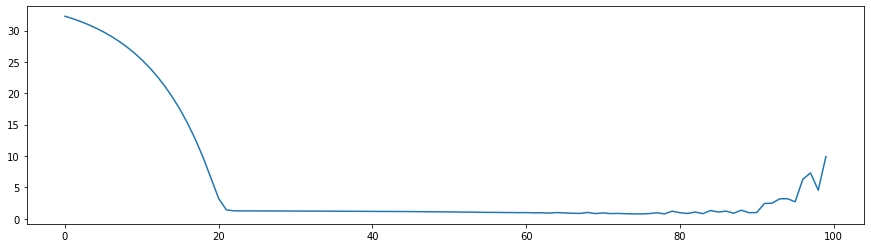

In [23]:
learnnig_rates=1e-8 * (10 ** (np.arange(100) / 20))
y=history.history['loss']

plt.figure(figsize=(15,4))
plt.plot(y);

In [24]:
#choose the learning rate that better minimizes the loss
lr=learnnig_rates[y.index(min(y))] 

In [25]:
tf.keras.backend.clear_session()
model.set_weights(init_weights)

model.compile(loss=keras.losses.Huber(),optimizer=keras.optimizers.SGD(learning_rate=lr,momentum=0.9),metrics=['mae'])

In [26]:
model.fit(train_data,epochs=80)

Epoch 1/80
90/90 [==============================] - 2s 7ms/step - loss: 4.3958 - mae: 4.8485
Epoch 2/80
90/90 [==============================] - 1s 6ms/step - loss: 1.1583 - mae: 1.5682
Epoch 3/80
90/90 [==============================] - 0s 4ms/step - loss: 1.2500 - mae: 1.6708
Epoch 4/80
90/90 [==============================] - 0s 3ms/step - loss: 1.0215 - mae: 1.4188
Epoch 5/80
90/90 [==============================] - 0s 3ms/step - loss: 0.9426 - mae: 1.3450
Epoch 6/80
90/90 [==============================] - 0s 4ms/step - loss: 0.9331 - mae: 1.3280
Epoch 7/80
90/90 [==============================] - 0s 4ms/step - loss: 0.8787 - mae: 1.2692
Epoch 8/80
90/90 [==============================] - 0s 3ms/step - loss: 0.8826 - mae: 1.2735
Epoch 9/80
90/90 [==============================] - 0s 4ms/step - loss: 0.8213 - mae: 1.2119
Epoch 10/80
90/90 [==============================] - 0s 3ms/step - loss: 0.8469 - mae: 1.2376
Epoch 11/80
90/90 [==============================] - 0s 4ms/step - lo

## Making the prediction

In [27]:
def get_prediction(series,window_size,batch_size,model):
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(window_size,shift=1,drop_remainder=True)
  dataset=dataset.flat_map(lambda window: window.batch(window_size))
  dataset=dataset.batch(batch_size).prefetch(1)
  predictions=model.predict(dataset)
  return predictions

In [28]:
new_series=series[split_num-window_size+1:]
prediction=get_prediction(new_series,window_size,batch_size,model)

## Final Plotting

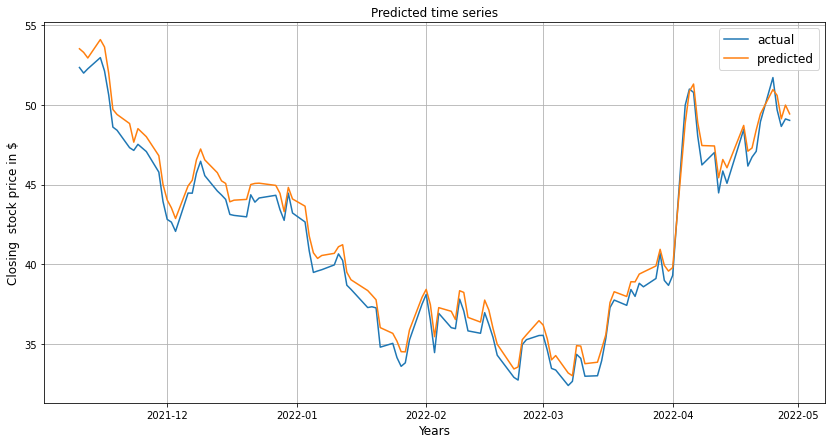

In [29]:
plt.figure(figsize=(14,7))
plt.plot(test_step,test_series,label='actual')
plt.grid()
plt.title('Predicted time series')
plt.plot(test_step,prediction,label='predicted')
plt.legend(fontsize=12)
plt.ylabel('Closing  stock price in $',fontsize=12)
plt.xlabel('Years',fontsize=12);
